# 5. Calibration of potential evaporation methods
*M. Vremec, R.A. Collenteur University of Graz, 2021*

In this notebook it is shown how to calibrate various (potential) evaporation (PE) equations, using a linear regression relationship between daily potential evaporation obtained with the FAO-56 equation and daily PE estimates obtained with the alternative methods. This notebook requires Scipy and SkLearn python packages to run.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

import pyet as pyet

## 1. Load KNMI Data

In [2]:
data = pd.read_csv("data//example_3//etmgeg_260.txt", skiprows=46, delimiter=",", 
                   skipinitialspace=True, index_col="YYYYMMDD", parse_dates=True).loc["2018",:]
data.head()

,# STN,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
2018-01-01,260,225,45,50,90,2,10,18,190.0,2.0,...,2.0,75.0,3.0,7.0,84,96,17,73,1,3
2018-01-02,260,216,39,45,80,24,20,1,140.0,24.0,...,19.0,75.0,8.0,7.0,88,96,3,80,8,2
2018-01-03,260,257,82,88,120,11,70,4,290.0,3.0,...,1.0,75.0,4.0,8.0,73,95,1,65,9,1
2018-01-04,260,238,51,56,90,20,30,14,180.0,20.0,...,14.0,80.0,21.0,8.0,82,97,14,67,21,2
2018-01-05,260,225,38,40,60,1,20,17,150.0,16.0,...,15.0,75.0,1.0,6.0,87,96,17,71,3,2


## 2.Estimation of evaporation

In [3]:
# define meteorological variables needed for PE estimation
meteo = pd.DataFrame({"tmean":data.TG/10, "tmax":data.TX/10, "tmin":data.TN/10, "rh":data.UG, "wind":data.FG/10, "rs":data.Q/100})
tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]
pressure =  data.PG / 100 # to kPa
wind = data.FG/10  # to m/s
lat = 0.91  # [rad]
elevation = 4 

pe_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, 
                         tmax=tmax, tmin=tmin, rh=rh)  # FAO-56 method
pe_romanenko = pyet.romanenko(tmean, rh)  # Romanenko method
pe_abtew = pyet.abtew(tmean, rs)  # Abtew method

The model performance of the Abtew and Romanenko method will be evaluated using the root mean square error (RMSE), as implemented in SkLearn’s mean_squared_error method.

RMSE(Romanenko) = 0.69196195271315 mm/d
RMSE(Abtew) = 0.7387164592178931 mm/d


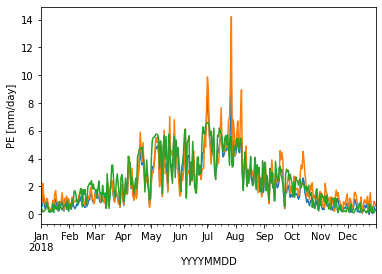

In [4]:
pe_fao56.plot()
pe_romanenko.plot()
pe_abtew.plot()
plt.ylabel("PE [mm/day]")
print("RMSE(Romanenko) = {} mm/d".format(mean_squared_error(pe_fao56, pe_romanenko, squared=False)))
print("RMSE(Abtew) = {} mm/d".format(mean_squared_error(pe_fao56, pe_abtew, squared=False)))

## 3. Calibration of different PE equations

The least squares approach is applied to estimate the parameters in the PE equations, by minimizing the sum of the residuals between the simulated (Abtew and Romanenko) and observed (FAO-56) data. The minimization of the objective function is done using the Trust Region Reflective algorithm, as implemented in Scipy’s least squares method.

### 3.1 Romanenko method

In [5]:
# Define function for computing residuals
def cal_romanenko(k, obs):
    return pyet.romanenko(tmean, rh, k)-obs

In [6]:
# estimate k in the Romanenko method
x0 = 4.5  # initial estimate of parameter
res_1 = least_squares(cal_romanenko, x0, args=[pe_fao56])
res_1.x

array([3.87304264])

In [7]:
# Compute RMSE using the calibrated value of k
pe_romanenko_cal = pyet.romanenko(tmean, rh, k=res_1.x)
print("RMSE(Romanenko) = {} mm/d".format(mean_squared_error(pe_fao56, pe_romanenko_cal, squared=False)))

RMSE(Romanenko) = 0.5470806398574546 mm/d


RMSE (calibrated) = 0.546 < RMSE (uncalibrated) = 0.694

### 3.2 Abtew method

In [8]:
# Define function for computing residuals and initial estimate of parameters
def cal_abtew(k,obs):
    return pyet.abtew(tmean, rs, k)-obs
x0 = 0.53

In [9]:
# estimate k in the Romanenko method
res_2 = least_squares(cal_abtew, x0, args=[pe_fao56])
res_2.x

array([0.4574895])

In [10]:
pe_abtew_cali = pyet.abtew(tmean, rs, res_2.x)
print("RMSE(Abtew) = {} mm/d".format(mean_squared_error(pe_fao56, pe_abtew_cali, squared=False)))

RMSE(Abtew) = 0.6127988797521065 mm/d


RMSE (calibrated) = 0.613 < RMSE (uncalibrated) = 0.741

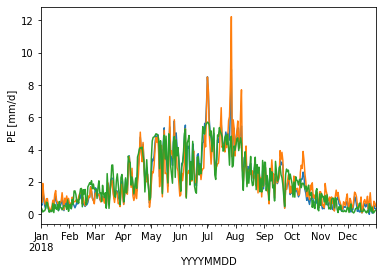

In [11]:
pe_fao56.plot()
pe_romanenko_cal.plot()
pe_abtew_cali.plot()
plt.ylabel("PE [mm/d]");